# Comparing different vertex-approaching policies

The purpose of this notebook is to demonstrate how to use `stochastic_matching` to observe the performance of policies designed to reach vertices of the stable polytope.

The protocol is as follows:
- We define the problem:
  - Model (graph and arrival rates)
  - Rewards associated to each edge
- We run the following policies:
  - $\epsilon$-filtering, for various values of $\epsilon$
  - $k$-filtering, for various values of $k$
  - $EGPD$, for various values of $\beta$
  
Note that the first two policies use the knowledge of the optimal vertex, computed using the model and rewards. The last one only uses the rewards and ignore the polytope structure.

Then we compute the following metrics to observe their trade-offs.
- Regret: difference between the reward rate of the optimal flow and the reward rate of the achieved flow.
- Delay: some of the average queue size over all item classes.

## Setup

We import some packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import stochastic_matching as sm
from multiprocess import Pool
from stochastic_matching import VariableParameter, evaluate

# change the default figure size
plt.rcParams['figure.figsize'] = (7, 3)
# prepare a pool of workers
p = Pool()

We make a function to wrap-up the experiments we want to perform.

In [2]:
n_steps = 10**9
e_range = np.logspace(-3, 0, 10)
k_range = [2**i for i in range(12)]
b_range = np.logspace(-3, 1, 10)

def make_xps(model, rewards):
    base = {'model': model, 'n_steps': n_steps, 'rewards': rewards, 'max_queue': 50000}
    return [
    VariableParameter(name='ϵ-filtering', simulator='e_filtering', 
                        key='epsilon', values=e_range, **base),
    VariableParameter(name='k-filtering', simulator='longest', forbidden_edges=True,
                        key='k', values=k_range, **base),
    VariableParameter(name='EGPD', simulator='virtual_queue',
                        key='beta', values=b_range, **base)
    ]

## Diamond graph

We start with a simple example on a diamond graph.

In [3]:
# define model
diamond = sm.Model(
    adjacency=np.array([[0, 1, 1, 0],
                        [1, 0, 1, 1],
                        [1, 1, 0, 1],
                        [0, 1, 1, 0]]),
    rates=[2, 3, 3, 2],
)
diamond.vertices

[{'kernel_coordinates': array([-1.]),
  'edge_coordinates': array([0., 2., 1., 2., 0.]),
  'null_edges': [0, 4],
  'bijective': False},
 {'kernel_coordinates': array([1.]),
  'edge_coordinates': array([2., 0., 1., 0., 2.]),
  'null_edges': [1, 3],
  'bijective': False}]

Let us try to reach the vertex with forbidden edges [1, 3].

### Gentle rewards

To start, we use gentle rewards, where the forbidden edges are clearly indicated.

In [4]:
rewards = np.array([1, -1, 1, -1, 1])
diamond.optimize_rates(rewards)

array([2., 0., 1., 0., 2.])

In [5]:
res = evaluate(make_xps(diamond, rewards), pool=p)

100%|██████████| 32/32 [05:45<00:00, 10.80s/it]  


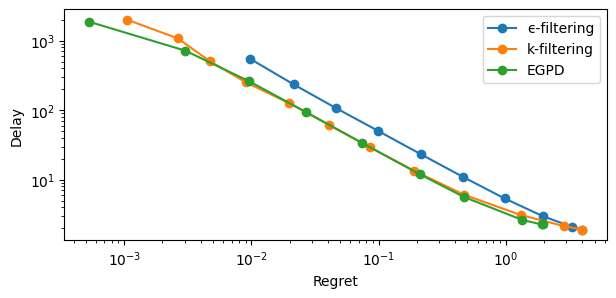

In [6]:
for k, v in res.items():
    plt.loglog(np.abs(v['regret']), np.abs(v['delay']), marker='o', label=k)
plt.xlabel('Regret')
plt.ylabel('Delay')
plt.legend()
plt.show()

EGPD and $k$-filtering have similar performance, with $\epsilon$-filtering coming third.

### Adversarial rewards

Now we choose rewards where one of the forbidden edges has the highest reward (the vertex remains the same).

In [7]:
rewards = np.array([1, 2.9, 1, -1, 1])
diamond.optimize_rates(rewards)

array([2., 0., 1., 0., 2.])

In [8]:
res = evaluate(make_xps(diamond, rewards), pool=p)

100%|██████████| 32/32 [05:48<00:00, 10.89s/it]  


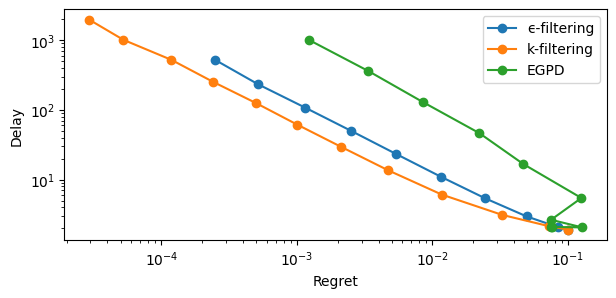

In [9]:
for k, v in res.items():
    plt.loglog(v['regret'], v['delay'], marker='o', label=k)
plt.xlabel('Regret')
plt.ylabel('Delay')
plt.legend()
plt.show()

EGPD is now way above $k$-filtering (best) and $\epsilon$-filtering (second best).

### Edge case

Now, we pick up a reward that is orthogonal to the polytope, e.g. any stable policy is optimal.

In [10]:
rewards = np.array([1, 3, 1, -1, 1])
rewards @ diamond.vertices[0]['edge_coordinates']

4.9999999999999964

In [11]:
rewards @ diamond.vertices[1]['edge_coordinates']

4.999999999999999

In [12]:
base = {'model': diamond, 'n_steps': n_steps, 'rewards': rewards, 'max_queue': 50000}
res = evaluate([
VariableParameter(name='k-filtering', simulator='longest', forbidden_edges=[0, 4],
                        key='k', values=k_range, **base),
VariableParameter(name='e-filtering', simulator='e_filtering', forbidden_edges=[0, 4],
                        key='epsilon', values=e_range, **base),
VariableParameter(name='Longest', simulator='longest',
                        key='k', values=[10000], **base),
VariableParameter(name='EGPD', simulator='virtual_queue',
                        key='beta', values=b_range, **base)], pool=p)

100%|██████████| 33/33 [07:33<00:00, 13.74s/it]  


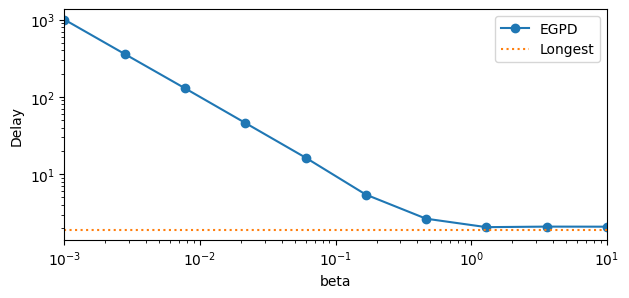

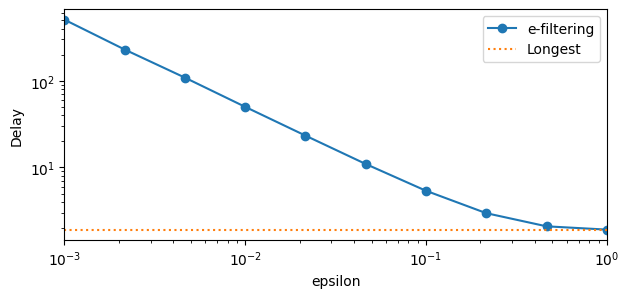

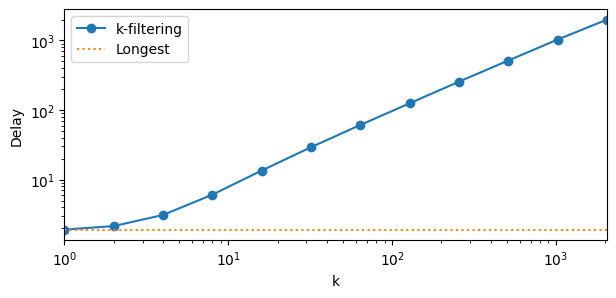

In [13]:
for pol, key in [('EGPD', 'beta'), ('e-filtering','epsilon'), ('k-filtering', 'k')]:
    x = res[pol][key]
    y = res[pol]['delay']
    yref = res['Longest']['delay'][0]
    plt.loglog(x, y, marker='o', label=pol)
    plt.loglog([min(x), max(x)], [yref, yref], ':', label='Longest')
    plt.xlim([min(x), max(x)])
    plt.xlabel(key)
    plt.ylabel('Delay')
    plt.legend()
    plt.show()

Here, all optimization policies pay a delay price to reach a vertex that doesn't need to be reached. They are all outperformed by a simple Longest policy.

## Co-domino, bijective vertex

Try a stable vertex from a co-domino.

In [14]:
bijective = sm.Model(
    adjacency=np.array([[0, 1, 1, 0, 0, 0],
                        [1, 0, 1, 1, 0, 0],
                        [1, 1, 0, 0, 1, 0],
                        [0, 1, 0, 0, 1, 1],
                        [0, 0, 1, 1, 0, 1],
                        [0, 0, 0, 1, 1, 0]]),
    rates=[4, 5, 5, 3, 3, 2],
)
bijective.vertices

[{'kernel_coordinates': array([-0.75, -1.  ]),
  'edge_coordinates': array([3., 1., 1., 1., 3., 0., 2., 0.]),
  'null_edges': [5, 7],
  'bijective': True},
 {'kernel_coordinates': array([-0.75,  1.  ]),
  'edge_coordinates': array([1., 3., 1., 3., 1., 0., 0., 2.]),
  'null_edges': [5, 6],
  'bijective': True},
 {'kernel_coordinates': array([0.25, 1.  ]),
  'edge_coordinates': array([1., 3., 2., 2., 0., 1., 0., 2.]),
  'null_edges': [4, 6],
  'bijective': True},
 {'kernel_coordinates': array([ 0.25, -1.  ]),
  'edge_coordinates': array([3., 1., 2., 0., 2., 1., 2., 0.]),
  'null_edges': [3, 7],
  'bijective': True},
 {'kernel_coordinates': array([1.25, 0.  ]),
  'edge_coordinates': array([2., 2., 3., 0., 0., 2., 1., 1.]),
  'null_edges': [3, 4],
  'bijective': True}]

We aim for [3, 7].

### Gentle rewards

In [15]:
rewards = [1, 1, 1, -1, 1, 1, 1, -1]
bijective.optimize_rates(rewards)

array([3., 1., 2., 0., 2., 1., 2., 0.])

In [16]:
res = evaluate(make_xps(bijective, rewards), pool=p)

100%|██████████| 32/32 [06:04<00:00, 11.40s/it]  


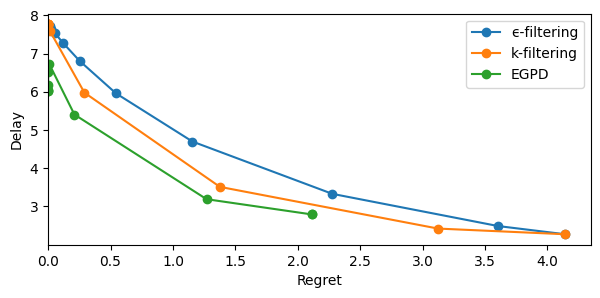

In [17]:
for k, v in res.items():
    plt.plot(v['regret'], v['delay'], marker='o', label=k)
plt.xlabel('Regret')
plt.ylabel('Delay')
plt.xlim([0, None])
plt.legend()
plt.show()

### Adversarial rewards

In [18]:
rewards = np.array([-1, -1, -.5, .4, 1.5, 2.5, -1, -1])
bijective.optimize_rates(rewards)

array([3., 1., 2., 0., 2., 1., 2., 0.])

In [19]:
res = evaluate(make_xps(bijective, rewards), pool=p)

100%|██████████| 32/32 [06:05<00:00, 11.42s/it]  


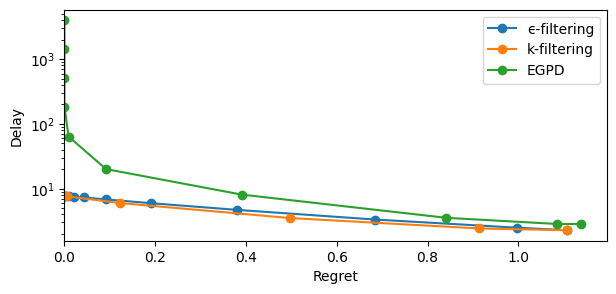

In [20]:
for k, v in res.items():
    plt.semilogy(v['regret'], v['delay'], marker='o', label=k)
plt.xlabel('Regret')
plt.ylabel('Delay')
plt.xlim([0, None])
plt.legend()
plt.show()

## Co-domino, injective vertex

In [21]:
# define model
injective = sm.Model(
    adjacency=np.array([[0, 1, 1, 0, 0, 0],
                        [1, 0, 1, 1, 0, 0],
                        [1, 1, 0, 0, 1, 0],
                        [0, 1, 0, 0, 1, 1],
                        [0, 0, 1, 1, 0, 1],
                        [0, 0, 0, 1, 1, 0]]),
    rates=[2, 4, 2, 4, 2, 2],
)
injective.vertices

[{'kernel_coordinates': array([-1.        , -0.66666667]),
  'edge_coordinates': array([2., 0., 0., 2., 2., 0., 2., 0.]),
  'null_edges': [1, 2, 5, 7],
  'bijective': False},
 {'kernel_coordinates': array([-1.        ,  1.33333333]),
  'edge_coordinates': array([0., 2., 0., 4., 0., 0., 0., 2.]),
  'null_edges': [0, 2, 4, 5, 6],
  'bijective': False},
 {'kernel_coordinates': array([ 1.        , -0.66666667]),
  'edge_coordinates': array([2., 0., 2., 0., 0., 2., 2., 0.]),
  'null_edges': [1, 3, 4, 7],
  'bijective': False}]

We choose [0, 2, 4, 5, 6].

### Gentle rewards

In [22]:
rewards = [-1, 1, -1, 1, -1, -1, -1, 1]
injective.optimize_rates(rewards)

array([0., 2., 0., 4., 0., 0., 0., 2.])

In [23]:
res = evaluate(make_xps(injective, rewards), pool=p)

100%|██████████| 32/32 [06:00<00:00, 11.27s/it]  


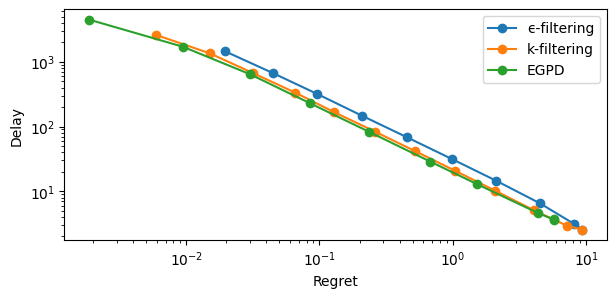

In [24]:
for k, v in res.items():
    plt.loglog(v['regret'], v['delay'], marker='o', label=k)
plt.xlabel('Regret')
plt.ylabel('Delay')
plt.legend()
plt.show()

### Adversarial rewards

In [25]:
rewards = np.array([-1, 1, -1, 1, 4.9, 4.9, -1, 1])
injective.optimize_rates(rewards)

array([0., 2., 0., 4., 0., 0., 0., 2.])

In [26]:
res = evaluate(make_xps(injective, rewards), pool=p)

100%|██████████| 32/32 [06:06<00:00, 11.45s/it]  


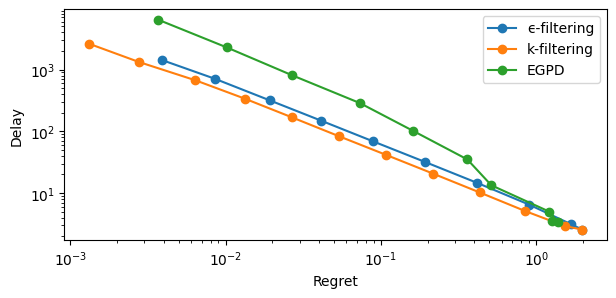

In [27]:
for k, v in res.items():
    plt.loglog(v['regret'], v['delay'], marker='o', label=k)
plt.xlabel('Regret')
plt.ylabel('Delay')
plt.legend()
plt.show()

## Hypergraph

Last but not least: Stolyar's example from https://arxiv.org/abs/1608.01646

The main difference compared to previous experiments is that we have a hypergraph instead of a simple graph. as a consequence, we use VQ-base policies instead of longest-based policies for $\epsilon$-filtering and $k$-filtering.

In [28]:
def make_hypergraph_xps(model, rewards):
    base = {'model': model, 'n_steps': n_steps, 'rewards': rewards, 'max_queue': 50000}
    ef = VariableParameter(name='ϵ-filtering', simulator='e_filtering', base_policy='virtual_queue',
                        key='epsilon', values=e_range, **base)
    kf = VariableParameter(name='k-filtering', simulator='virtual_queue', forbidden_edges=True,
                        key='k', values=k_range, **base)
    rf = VariableParameter(name='EGPD', simulator='virtual_queue',
                        key='beta', values=b_range, **base)
    return [ef, kf, rf]

In [29]:
hypergraph = sm.Model(incidence=[[1, 0, 0, 0, 1, 0, 0],
                                [0, 1, 0, 0, 1, 1, 1],
                                [0, 0, 1, 0, 0, 1, 1],
                                [0, 0, 0, 1, 0, 0, 1]], rates=[1.2, 1.5, 2, .8])
hypergraph.vertices

[{'kernel_coordinates': array([-0.95137114, -1.39721027, -1.8187728 ]),
  'edge_coordinates': array([1.2, 1.5, 2. , 0.8, 0. , 0. , 0. ]),
  'null_edges': [4, 5, 6],
  'bijective': True},
 {'kernel_coordinates': array([-0.87751221, -1.00105977, -0.27035114]),
  'edge_coordinates': array([1.2, 0.7, 1.2, 0. , 0. , 0. , 0.8]),
  'null_edges': [3, 4, 5],
  'bijective': True},
 {'kernel_coordinates': array([-0.78310692,  0.12871187,  0.15942051]),
  'edge_coordinates': array([1.2, 0. , 0.5, 0. , 0. , 0.7, 0.8]),
  'null_edges': [1, 3, 4],
  'bijective': True},
 {'kernel_coordinates': array([-0.74907409,  1.02372897, -0.89783356]),
  'edge_coordinates': array([1.2, 0. , 0.5, 0.8, 0. , 1.5, 0. ]),
  'null_edges': [1, 4, 6],
  'bijective': True},
 {'kernel_coordinates': array([ 0.28485256, -0.75722774, -0.02651911]),
  'edge_coordinates': array([0.5, 0. , 1.2, 0. , 0.7, 0. , 0.8]),
  'null_edges': [1, 3, 5],
  'bijective': True},
 {'kernel_coordinates': array([ 1.04125419, -0.9792125 , -1.40077

Aim for [0, 1, 5], as in the original example. Note that the example is bijective, so little delay is expected.

### Gentle rewards

In [30]:
rewards = [-1, -1, 1, 1, 1, -1, 1]
hypergraph.optimize_rates(rewards)

array([0. , 0. , 1.7, 0.5, 1.2, 0. , 0.3])

In [31]:
res = evaluate(make_hypergraph_xps(hypergraph, rewards), pool=p)

100%|██████████| 32/32 [08:36<00:00, 16.14s/it]  


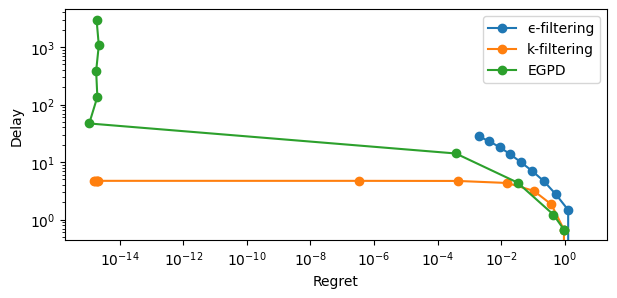

In [32]:
for k, v in res.items():
    plt.loglog(np.abs(v['regret']), np.abs(v['delay']), marker='o', label=k)
plt.xlabel('Regret')
plt.ylabel('Delay')
plt.legend()
plt.show()

### Original rewards

In [33]:
rewards = [-1, -1, 1, 2, 5, 4, 7]
hypergraph.optimize_rates(rewards)

array([0. , 0. , 1.7, 0.5, 1.2, 0. , 0.3])

In [34]:
res = evaluate(make_hypergraph_xps(hypergraph, rewards), pool=p)

100%|██████████| 32/32 [09:32<00:00, 17.88s/it]  


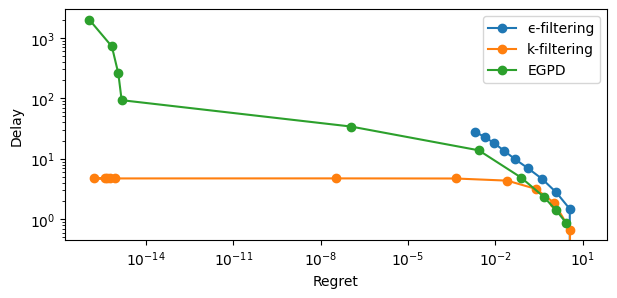

In [35]:
for k, v in res.items():
    plt.loglog(np.abs(v['regret']), np.abs(v['delay']), marker='o', label=k)
plt.xlabel('Regret')
plt.ylabel('Delay')
# plt.xlim([0, 4])
plt.legend()
plt.show()

In [36]:
p.close()